In [1]:
from exactvu.data.dataset import PatchesDatasetNew, PatchViewConfig
from torch.utils.data import WeightedRandomSampler
from exactvu.data.utils import data_dir
import os
import torch 

from exactvu.data.splits import Splits, SplitsConfig, CENTERS

s = Splits(SplitsConfig(cohort_specifier=["UVA", "CRCEO", "JH", "PCC", "PMCC"], balance_classes=False))

from exactvu.data.transforms import TransformV2, TransformConfig, PrebuiltConfigs

t = TransformV2(PrebuiltConfigs.CROPS)

center2code = {
    center: i for i, center in enumerate(CENTERS)
}
m_t = lambda metadata: torch.tensor(
    center2code[metadata['center']]
)


train_ds = PatchesDatasetNew(
    root=os.path.join(data_dir(), "cores_dataset"),
    patch_view_config=PatchViewConfig(prostate_region_only=False),
    core_specifier_list=s.get_train(merge_centers=True),
    patch_transform=t,
    metadata_transform=m_t
)

val_ds = PatchesDatasetNew( 
    root=os.path.join(data_dir(), "cores_dataset"),
    patch_view_config=PatchViewConfig(prostate_region_only=False),
    core_specifier_list=s.get_val(merge_centers=True),
    patch_transform=t,
    metadata_transform=m_t
)

test_ds = PatchesDatasetNew( 
    root=os.path.join(data_dir(), "cores_dataset"),
    patch_view_config=PatchViewConfig(prostate_region_only=False),
    core_specifier_list=s.get_test(merge_centers=True),
    patch_transform=t,
    metadata_transform=m_t
)


Preparing cores:   0%|          | 17/4066 [00:40<2:41:42,  2.40s/it]


KeyboardInterrupt: 

In [2]:
from torch.utils.data import dataloader
import numpy as np
from tqdm import tqdm

def get_center_labels(ds: PatchesDatasetNew):

    center_labels = []
    for core, patch_view in tqdm(zip(ds.cores, ds.patch_views), desc='Gathering center labels'):
        center = core.metadata['center']
        code = center2code[center]
        center_labels.extend([code] * len(patch_view))

    return np.array(center_labels)


def get_weights(labels: np.ndarray): 
    """computes weights for a sampler"""

    weights = np.zeros_like(labels)

    for label in np.unique(labels): 
        ind = labels == label
        weight = 1 / np.sum(ind)
        weights = np.where(ind, weight, weights)

    return weights


def make_sampler(ds: PatchesDatasetNew):
    labels = get_center_labels(ds)
    weights = get_weights(labels)

    return WeightedRandomSampler(
        list(weights), len(weights), replacement=True
    )


def make_dataloader(ds: PatchesDatasetNew, train=True):
    return dataloader.DataLoader(
        ds, 
        64, 
        sampler=make_sampler(ds) if train else None,    
    )

In [3]:
train_dl = make_dataloader(train_ds, True)
val_dl = make_dataloader(val_ds, False)
test_dl = make_dataloader(test_ds, False)

Gathering center labels: 980it [00:11, 82.67it/s]


In [4]:
batch = next(iter(train_dl))

In [5]:
import pytorch_lightning as pl 
from torchmetrics.classification import Accuracy
from exactvu.models.backbones import create_backbone


class CenterDetector(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.backbone = create_backbone('resnet_10_default_backbone')
        self.clf = torch.nn.Linear(512, 5)
        self.train_acc = Accuracy(num_classes=5, average='macro')
        self.val_acc = Accuracy(num_classes=5, average='macro')
        self.test_acc = Accuracy(num_classes=5, average='macro')

    def forward(self, patches):
        return self.clf(self.backbone(patches))

    def training_step(self, batch, *args, **kwargs):
        X, pos, y, center = batch 
        logits = self(X)
        
        self.train_acc(logits, center)
        self.log('train/macro_acc', self.train_acc)

        return torch.nn.functional.cross_entropy(logits, center)

    def validation_step(self, batch, *args, **kwargs):
        X, pos, y, center = batch 
        logits = self(X)
        
        self.val_acc(logits, center)
        self.log('val/macro_acc', self.val_acc)

    def test_step(self, batch, *args, **kwargs):
        X, pos, y, center = batch 
        logits = self(X)
        
        self.test_acc(logits, center)
        self.log('test/macro_acc', self.test_acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

model = CenterDetector()

In [6]:
from pytorch_lightning.loggers import WandbLogger

logger = WandbLogger(name='center guessing')

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pfrwilson. Use `wandb login --relogin` to force relogin
/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help` for usage information.




In [7]:
trainer = pl.Trainer(
    logger=logger,
    accelerator="gpu",
    devices=[0],
    max_epochs=20,
    callbacks=[pl.callbacks.EarlyStopping(monitor="val/macro_acc", mode="max")],
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(model, train_dl, val_dataloaders=val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type     | Params
---------------------------------------
0 | backbone  | ResNet   | 4.9 M 
1 | clf       | Linear   | 2.6 K 
2 | train_acc | Accuracy | 0     
3 | val_acc   | Accuracy | 0     
4 | test_acc  | Accuracy | 0     
---------------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.608    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/paulw/anaconda3/envs/exact/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/paulw/anaconda3/envs/exact/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
model = CenterDetector()
model.training_step(batch)

/home/paulw/anaconda3/envs/exact/lib/python3.9/site-packages/pytorch_lightning/core/lightning.py:374: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(


tensor(1.6532, grad_fn=<NllLossBackward0>)

In [ ]:
batch.metadata

tensor([2, 0, 4, 0, 4, 2, 3, 3, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 4, 1, 2, 3, 3, 3,
        0, 3, 1, 4, 2, 1, 1, 1, 4, 2, 3, 1, 4, 4, 3, 4, 3, 1, 2, 0, 2, 1, 3, 3,
        4, 1, 2, 1, 1, 3, 2, 4, 3, 3, 4, 4, 2, 3, 1, 3])

In [ ]:
labels = np.array([1, 1, 1, 1, 1, 0, 0,])

In [ ]:
x = labels == 0

In [ ]:
np.where(x, 0.5, labels)

array([1. , 1. , 1. , 1. , 1. , 0.5, 0.5])

In [ ]:
get_weights(np.array([1, 1, 1, 1, 1, 0, 0,]))

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.5, 0.5])

In [ ]:
from exactvu.resources import metadata
metadata()

0       CRCEO
1       CRCEO
2       CRCEO
3       CRCEO
4       CRCEO
        ...  
6602      UVA
6603      UVA
6604      UVA
6605      UVA
6606      UVA
Name: center, Length: 6607, dtype: object

In [ ]:
train_ds.metadata['center']

0      CRCEO
1      CRCEO
2      CRCEO
3      CRCEO
4      CRCEO
       ...  
975      UVA
976      UVA
977      UVA
978      UVA
979      UVA
Name: center, Length: 980, dtype: object

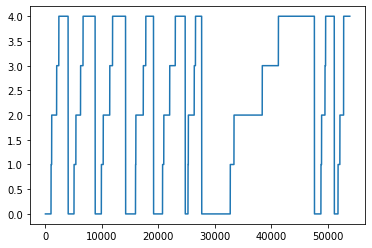

In [ ]:
import matplotlib.pyplot as plt
plt.plot(get_center_labels(train_ds))

In [ ]:
len(train_ds)

53900

In [ ]:
train_ds.get_item_and_subitem_idx(1000)

(18, 10)